# clusters of schools
https://levelup.gitconnected.com/clustering-gps-co-ordinates-forming-regions-4f50caa7e4a1

In [1]:
from importlib import reload
import houses.__main__
reload(houses.__main__)
from houses.__main__ import SchoolsStorage
import pandas as pd

In [2]:
storage = SchoolsStorage.init()

## One method to validate the number of clusters is the elbow method.

The idea of the elbow method is to run k-means clustering on the dataset for a range of values of k (say, k from 1 to 10), and for each value of k calculate the Sum of Squared Errors (SSE).

When K increases, the centroids are closer to the clusters centroids. The improvements will decline rapidly at some point, creating the elbow shape. That is the optimal value for K.

This might take a while.. stretch a little.

In [43]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
def plot_elbow(k):
    k_clusters = range(1, k)
    kmeans = [KMeans(n_clusters=i) for i in k_clusters]
    y_axis = df[['latitude']]
    x_axis = df[['longitude']]
    score = [kmeans[i].fit(y_axis).score(y_axis) for i in range(len(kmeans))]
    # Visualize
    plt.plot(k_clusters, score)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Curve')
    plt.show()

In [ ]:
%time plot_elbow(40)

When we graph the plot, we see that the graph levels off slowly after 3 clusters. This implies that addition of more clusters will not help us that much.

In [ ]:
KMeans?

In [41]:
def cluster_schools_by_location(*, dataframe, n_scools_in_cluster):
    kmeans = KMeans(n_clusters = int(len(dataframe) / n_scools_in_cluster), init ='random')
    coordinates = dataframe.columns[dataframe.columns.get_loc('latitude'):dataframe.columns.get_loc('longitude') + 1]
    kmeans.fit(dataframe[coordinates]) # Compute k-means clustering.
    dataframe['cluster_label'] = kmeans.fit_predict(dataframe[coordinates])
    centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
    labels = kmeans.predict(dataframe[coordinates]) # Labels of each point
    return centers, labels

In [ ]:
def get_cluster(*, dataframe, cluster_n):
    return dataframe[dataframe['cluster_label']==cluster_n]

## Visualise cluster

In [3]:
import folium
# https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/Plugins.ipynb
import folium.plugins
import itertools
import folium.vector_layers


def make_popup(school):
    ofsted_report = (
        'Absent report' 
        if not school.latest_ofsted["effectiveness"] 
        else f'{school.latest_ofsted["effectiveness"]} - {school.latest_ofsted["date"]}')
    return folium.Popup(max_width=450, html=f"""
<b>{school['schname']}</b> in {school['town']}
</br>
URN: {school['urn']}</br>
Postcode: {school['postcode']}</br>
Group: {school['minorgroup']}</br>
Type: {school['schooltype']}</br>
Age: {school['agelow']} - {school['agehigh']}</br>
<b>Ofsted</b>: {ofsted_report}
""")

RED_COLOUR = '#C30054'
GREY_COLOUR = '#525054'

MARKER_FILL_COLOUR_BY_SCHOOL_EFFECTIVENESS = {
    'Outstanding': 'green',
    'Good': 'blue',
    'Inadequate': 'red',
    'Requires improvement': 'yellow',
}

def make_marker(*, school: dict, circle_radius_meters=None) -> folium.Marker:
    marker_cls = folium.Circle if circle_radius_meters else folium.Marker
    effectiveness = school.latest_ofsted.get("effectiveness")
    colour = MARKER_FILL_COLOUR_BY_SCHOOL_EFFECTIVENESS.get(effectiveness, 'gray')
    attrs = dict(
        radius=circle_radius_meters,
        color='#3186cc',
        fill=True,
        fill_color='#3186cc',
    ) if circle_radius_meters else {}
    return marker_cls(
        [school.latitude, school.longitude], 
        popup=make_popup(school), 
        tooltip=school.schname,
        icon=folium.Icon(color=colour, angle=25, icon='bookmark'),
        **attrs,
    )
    

def vis_schools(*, dataframe, cluster_n, radius_around_schl_meters=0):
    rows = dataframe.iterrows()
    idx, first = next(rows)
    m = folium.Map(location=[first['latitude'], first['longitude']],
                # tiles='Stamen Toner', 
                zoom_start=13)
    for idx, school in itertools.chain(((idx, first),), rows):
        make_marker(school=school, circle_radius_meters=radius_around_schl_meters).add_to(m)
    folium.plugins.Fullscreen(
        position="topright",
        title="Expand me",
        title_cancel="Exit me",
        force_separate_button=True,
    ).add_to(m)
    return m

def vis_cluster(*, dataframe, cluster_n):
    cluster = get_cluster(dataframe=dataframe, cluster_n=cluster_n)
    return cluster, vis_schools(dataframe=cluster, cluster_n=cluster_n)

In [4]:
def collect_and_vis(*, towns=None, boroughs=None, n_schools_in_cluster=3, radius_around_schl_meters=0, postcode_areas=(), agehigh=18, agelow=11, ignore_girls_school=True, ignore_bad_ofsted=True):
    all_schools_df =  pd.DataFrame(storage.iter_schools(towns=towns, boroughs=boroughs, postcode_areas=postcode_areas, 
                                                        agelow=agelow, agehigh=agehigh, 
                                                        ignore_girls_school=ignore_girls_school, 
                                                        ignore_bad_ofsted=ignore_bad_ofsted))
    print(f'Total schools found: {len(all_schools_df)}')
    if not len(all_schools_df):
        return None, None
    if len(all_schools_df) <= n_schools_in_cluster or n_schools_in_cluster == 1:
        filtered_by_min_schools_number = all_schools_df
    else:
        cluster_schools_by_location(dataframe=all_schools_df, n_scools_in_cluster=n_schools_in_cluster)
        print("N of clusters: " + str(max(all_schools_df.cluster_label.unique())))
        filtered_by_min_schools_number = all_schools_df.groupby('cluster_label').filter(
            lambda x: len(x) >= n_schools_in_cluster)

        print(f'After filtering clusters by min number ({n_schools_in_cluster}) of schools: '
              f'{len(filtered_by_min_schools_number.cluster_label.unique())} clusters left')
    return filtered_by_min_schools_number, vis_schools(dataframe=filtered_by_min_schools_number, cluster_n='all', radius_around_schl_meters=radius_around_schl_meters)

# Add properties

In [5]:
import houses.zoopla
reload(houses.zoopla)
from houses.zoopla import ListedProperty
zoopla = houses.zoopla.get_client(token="jd74f2eeskshemzzdaxuzqhw")

In [54]:
from datetime import date

def make_property_popup(listed: ListedProperty):
    floor_plan = '\n</br>'.join([
        f'<img src="{plan_img_url}" style="width: 50%; height: 50%"></img>'
        for plan_img_url in listed.floor_plan
    ]
    )
    return folium.Popup(max_width=950, max_height=950, html=f"""
    <a href="https://www.zoopla.co.uk/for-sale/details/{listed.listing_id}">Zoopla link</a>
</br>{listed.property_type} - {listed.num_bathrooms}bath - price{listed.price}
</br>
</br>Bedrooms: {listed.num_bedrooms}
</br><img src="{listed.image_80_60_url}"></img>
</br>{floor_plan}
""")
    

def make_property_marker(*, listed: ListedProperty) -> folium.Marker:
    return folium.Marker(
            [listed.latitude, listed.longitude], 
            popup=make_property_popup(listed), 
            tooltip=f'{listed.property_type} - {listed.num_bedrooms}beds - £{listed.price}',
            icon=folium.Icon(icon='home', color='lightgray'),
        )

def add_properties_to_map(*, zoopla_client, map, dataframe, 
                          radius_miles=0.5, 
                          only_new_homes=False,
                          only_flats=False,
                          maximum_price=400_000, min_beds=2,
                          exclude_leasehold=False,
                          
                         ):
    postcodes = dataframe.postcode.unique().tolist()
    print(f'Date of search {date.today()}')
    print(f'Search properties for postcodes: {postcodes}')
    listings = [
        listing
        for postcode in postcodes
        for result in (zoopla_client.list_listings(
            postcode=postcode, 
            radius_miles=radius_miles, 
            maximum_price=maximum_price,
            only_new_homes=only_new_homes,
            only_flats=only_flats,
            minimum_beds=min_beds),)
        for listing in result.listing
    ]
    print(f'Found {len(listings)} properties in listing')
    if exclude_leasehold:
        listings = [
            l for l in listings
            if'leasehold' not in l.description.lower()
        ]
        print(f'After excluding leasehold: {len(listings)}')
    for l in listings:
        make_property_marker(listed=l).add_to(map)

# Explore specific boroughs

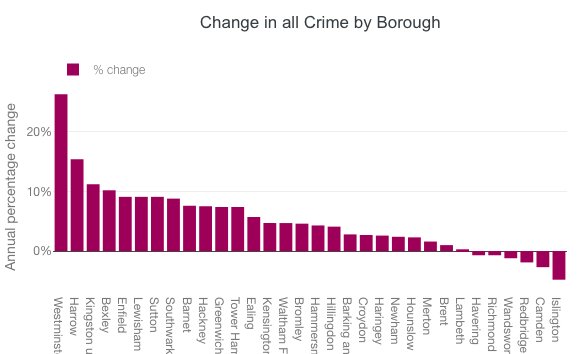

https://data.london.gov.uk/

In [35]:
BOROUGHS_OF_INTEREST = (
    'Havering', 
    'Richmond upon Themes', 
    'Bromley',
    'Bexley',
    'Sutton',
    'Kingston upon Thames', 
    'Wandsworth',
    'Islington',
    'Hammersmith and Fullham'
    'Camden',
    'Merton',
    'Barnet',
    'Enfield',
    'Haringey',
    'Croydon',
    'Greenwich',
    'Ealing',
    'Wallington',
                        
                        )

In [24]:
from pathlib import Path
import enum

In [25]:
atlas_path = Path('../data/london-borough-atlas.xlsx').absolute()
class AtlasSheet(enum.Enum):
    population = 'iadatasheet1'

In [26]:

atlas_df_by_sheet_name = pd.read_excel(
    atlas_path, sheet_name=[AtlasSheet.population.value, ], 
    # use header 2 as if we use 0,1,2 it will create MultiIndex that's harder to operate with
    header=2)

In [ ]:
atlas_df_by_sheet_name[AtlasSheet.population.value].columns.tolist()

In [36]:
atlas_population = atlas_df_by_sheet_name[AtlasSheet.population.value]
area_of_interest = atlas_population[atlas_population['Area name'].isin(BOROUGHS_OF_INTEREST)]
area_of_interest = area_of_interest[[
    'Area name',
    'Percentage BAME',
    # % of Secondary School Pupils who's first language is known or believed to be other than English
    2016,
    'Christian',
    'Muslim',
    'Largest migrant population by country of birth (Census 2011)',
    '% of largest migrant population (Census 2011)',
    'Second largest migrant population by country of birth (Census 2011)',
    '% of second largest migrant population (Census 2011)',
    # Largest migrant population arrived in the year
    '2015/16.1',
    # Second largest migrant population arrived in the year
    '2015/16.2',
#     'Third largest migrant population by country of birth (Census 2011)',
#     '% of third largest migrant population (Census 2011)',
    # % of borough total of largest migrant population
    '2015/16.4',
]].sort_values([
    'Percentage BAME',
    'Muslim',
    '% of largest migrant population (Census 2011)', 
                '% of second largest migrant population (Census 2011)', 
#                '% of third largest migrant population (Census 2011)'
])
area_of_interest

Area name Percentage BAME  2016 Christian Muslim  \
15              Havering            12.3  10.6        66      2   
5                Bromley            15.7   9.3        61      4   
3                 Bexley            18.1  13.3        68      4   
28                Sutton            21.4  22.2        52      7   
20  Kingston upon Thames            25.5  30.5        58      9   
31            Wandsworth            28.6  45.3        48      9   
18             Islington            31.8  45.9        43      9   
23                Merton            35.1    36        56     10   
2                 Barnet            35.9  38.8        41     11   
10             Greenwich            37.5  34.4        56      5   
9                Enfield              39    45        51     19   
13              Haringey            39.5  47.4        42     17   
7                Croydon            44.9  26.3        59     12   
8                 Ealing              51  54.3        45     19   

   Largest migrant population by country of birth (Census 2011)  \
15                                            Ireland             
5                                               India             
3                                             Nigeria             
28                                          Sri Lanka             
20                                          Sri Lanka             
31                                             Poland             
18                                            Ireland             
23                                             Poland             
2                                               India             
10                                            Nigeria             
9                                              Turkey             
13                                             Poland             
7                                               India             
8                                               India             

   % of largest migrant population (Census 2011)  \
15                                           1.1   
5                                            1.1   
3                                            2.6   
28                                           1.8   
20                                           2.2   
31                                           2.2   
18                                           2.8   
23                                           3.5   
2                                            3.1   
10                                           5.1   
9                                            4.5   
13                                           4.3   
7                                            3.6   
8                                            7.6   

   Second largest migrant population by country of birth (Census 2011)  \
15                                              India                    
5                                             Ireland                    
3                                               India                    
28                                              India                    
20                                              India                    
31                                       South Africa                    
18                                             Turkey                    
23                                          Sri Lanka                    
2                                              Poland                    
10                                              Nepal                    
9                                              Cyprus                    
13                                             Turkey                    
7                                             Jamaica                    
8                                              Poland                    

   % of second largest migrant population (Census 2011) 2015/16.1  2015/16.2  \
15                             

In [39]:
def current_search(boroughs=None, towns=None, exclude_leasehold=False):
    """Define current search params"""
    clustered, map = collect_and_vis(
        # college is next if it's only 16
        agehigh=16, 
        boroughs=boroughs, towns=towns,
        # we have a mixed feeling about schools for girls only
        ignore_girls_school=False, 
        # no clustering - 1 school in proximity is fine at the moment
        n_schools_in_cluster=2,
        ignore_bad_ofsted=True,
    )
    if clustered is not None and not clustered.empty and (towns or boroughs):
        add_properties_to_map(
            zoopla_client=zoopla, map=map, 
            dataframe=clustered, 
            maximum_price=420_000, 
            radius_miles=1,
            only_flats=False,
            min_beds=2,
            exclude_leasehold=True,
        )
    else:
        print('Looks like nothing for your search')
    return map

In [47]:
current_search()

Mongo query: [{'schstatus': 'Open'}, {'issecondary': '1'}, {'gender': {'$ne': 'Boys'}}, {'location': {'$exists': True}}, {'agehigh': {'$gte': '16'}}, {'agelow': {'$lte': '11'}}]
Total schools found: 2506
N of clusters: 1252
After filtering clusters by min number (2) of schools: 736 clusters left
Looks like nothing for your search


# Woking

In [55]:
current_search(towns=["Abingdon"])

Mongo query: [{'schstatus': 'Open'}, {'issecondary': '1'}, {'gender': {'$ne': 'Boys'}}, {'location': {'$exists': True}}, {'town': {'$in': ['Abingdon']}}, {'agehigh': {'$gte': '16'}}, {'agelow': {'$lte': '11'}}]
Total schools found: 1
Date of search 2021-05-13
Search properties for postcodes: ['OX14 1NP']
Found 10 properties in listing


# Ealing

In [8]:
clustered, map = collect_and_vis(boroughs=('Ealing',), ignore_girls_school=True, 
                                 n_schools_in_cluster=1,
                                ignore_bad_ofsted=True,
                                )
add_properties_to_map(zoopla_client=zoopla, radius_miles=1, map=map,
                      only_new_homes=True,
                      dataframe=clustered, maximum_price=400_000, min_beds=2)
map

Mongo query: [{'schstatus': 'Open'}, {'issecondary': '1'}, {'gender': {'$ne': 'Boys'}}, {'location': {'$exists': True}}, {'gender': {'$ne': 'Girls'}}, {'agehigh': {'$gte': '18'}}, {'agelow': {'$lte': '11'}}, {'laname': {'$in': ('Ealing',)}}]
Total schools found: 15
Date of search 2021-05-13
Search properties for postcodes: ['UB1 3BT', 'UB6 9AW', 'W7 1JJ', 'UB1 2GU', 'UB5 4HP', 'UB5 6AG', 'W7 3JP', 'W7 2AH', 'W7 1EU', 'W3 9PP', 'UB2 5HF', 'UB6 8PR', 'W7 2BB', 'UB1 3HZ']
Found 63 properties in listing


## Hillingdon

In [825]:
clustered, map = collect_and_vis(boroughs=('Hillingdon',), ignore_girls_school=True, n_schools_in_cluster=1, ignore_bad_ofsted=True)
add_properties_to_map(zoopla_client=zoopla, radius_miles=1, map=map, dataframe=clustered, maximum_price=400_000, min_beds=2)
map

Mongo query: [{'schstatus': 'Open'}, {'issecondary': '1'}, {'gender': {'$ne': 'Boys'}}, {'location': {'$exists': True}}, {'gender': {'$ne': 'Girls'}}, {'agehigh': {'$gte': '18'}}, {'agelow': {'$lte': '11'}}, {'laname': {'$in': ('Hillingdon',)}}]
Total schools found: 14
Search properties for postcodes: ['UB3 1PB', 'UB8 3QU', 'HA5 2LX', 'HA4 0LS', 'UB3 2SE', 'UB4 8JP', 'HA4 8EE', 'UB8 3RF', 'UB10 8AB', 'HA6 1QN', 'UB4 9LE', 'UB10 8QY', 'UB8 3BF', 'HA4 0BY']
Found 37 properties in listing


## Sutton

In [37]:
current_search(boroughs=('Sutton',))

Mongo query: [{'schstatus': 'Open'}, {'issecondary': '1'}, {'gender': {'$ne': 'Boys'}}, {'location': {'$exists': True}}, {'agehigh': {'$gte': '16'}}, {'agelow': {'$lte': '11'}}, {'laname': {'$in': ('Sutton',)}}]
Total schools found: 10
Date of search 2020-12-19
Search properties for postcodes: ['SM5 3PS', 'SM2 5SJ', 'SM2 6TQ', 'SM3 8PW', 'SM6 0PH', 'SM3 8AB', 'SM5 2QX', 'SM1 3DY', 'SM3 9PS', 'SM2 5RD']
Found 100 properties in listing


## Camdem

In [815]:
clustered, map = collect_and_vis(boroughs=('Camden',), 
                                 ignore_girls_school=True, n_schools_in_cluster=1, ignore_bad_ofsted=False)
add_properties_to_map(
    zoopla_client=zoopla, 
    radius_miles=1, 
    map=map, 
    only_new_homes=False,
    dataframe=clustered, maximum_price=400_000, min_beds=2)
map

Mongo query: [{'schstatus': 'Open'}, {'issecondary': '1'}, {'gender': {'$ne': 'Boys'}}, {'location': {'$exists': True}}, {'gender': {'$ne': 'Girls'}}, {'agehigh': {'$gte': '18'}}, {'agelow': {'$lte': '11'}}, {'laname': {'$in': ('Camden',)}}]
Total schools found: 6
Search properties for postcodes: ['NW3 2BQ', 'NW1 1RX', 'NW2 3RT', 'NW5 1UJ', 'NW1 1LY', 'NW3 3AQ']


<ipython-input-778-f73907f4e705>:47: UserWarning: color argument of Icon should be one of: {'cadetblue', 'orange', 'white', 'lightred', 'blue', 'lightgray', 'green', 'lightgreen', 'gray', 'pink', 'purple', 'darkgreen', 'beige', 'black', 'darkred', 'lightblue', 'darkpurple', 'darkblue', 'red'}.
  icon=folium.Icon(color=colour, angle=25, icon='bookmark'),


Found 0 properties in listing


##  Barnet

In [816]:
clustered, map = collect_and_vis(boroughs=('Barnet',), 
                                 ignore_girls_school=False, n_schools_in_cluster=1, ignore_bad_ofsted=False)
add_properties_to_map(
    zoopla_client=zoopla, 
    radius_miles=1, 
    map=map, 
    only_new_homes=False,
    dataframe=clustered, maximum_price=400_000, min_beds=2)
map


Mongo query: [{'schstatus': 'Open'}, {'issecondary': '1'}, {'gender': {'$ne': 'Boys'}}, {'location': {'$exists': True}}, {'gender': {'$ne': 'Girls'}}, {'agehigh': {'$gte': '18'}}, {'agelow': {'$lte': '11'}}, {'laname': {'$in': ('Barnet',)}}]
Total schools found: 18
Search properties for postcodes: ['NW9 5PE', 'EN4 0NJ', 'NW2 1TR', 'EN4 9GE', 'N14 5RJ', 'N12 0QG', 'EN4 8PU', 'NW7 4LL', 'N2 0SE', 'NW4 2HP', 'N11 1NP', 'N2 0SQ', 'N2 0QY', 'N20 8AZ', 'EN4 8XE', 'NW9 5FN', 'EN5 2DN']
Found 20 properties in listing


## Merton

In [824]:
clustered, map = collect_and_vis(boroughs=('Merton',), 
                                 ignore_girls_school=False, 
                                 n_schools_in_cluster=1, 
                                 ignore_bad_ofsted=False,
                                agehigh=16)
add_properties_to_map(
    zoopla_client=zoopla, 
    radius_miles=1, 
    map=map, 
    only_new_homes=False,
    dataframe=clustered, maximum_price=400_000, min_beds=2)
map


Mongo query: [{'schstatus': 'Open'}, {'issecondary': '1'}, {'gender': {'$ne': 'Boys'}}, {'location': {'$exists': True}}, {'agehigh': {'$gte': '16'}}, {'agelow': {'$lte': '11'}}, {'laname': {'$in': ('Merton',)}}]
Total schools found: 10
Search properties for postcodes: ['SW19 7HB', 'SW20 0JL', 'SW20 8HA', 'SW19 4TT', 'CR4 3BE', 'CR4 1BP', 'CR4 1SF', 'SM4 6DU', 'CR4 2QA', 'SW20 9NS']
Found 23 properties in listing


# Kidbrooke

In [21]:
current_search(boroughs=('Greenwich',))

Mongo query: [{'schstatus': 'Open'}, {'issecondary': '1'}, {'gender': {'$ne': 'Boys'}}, {'location': {'$exists': True}}, {'agehigh': {'$gte': '16'}}, {'agelow': {'$lte': '11'}}, {'laname': {'$in': ('Greenwich',)}}]
Total schools found: 14
Date of search 2020-12-17
Search properties for postcodes: ['SE9 5EE', 'SE3 9PX', 'SE10 8HN', 'SE12 8UF', 'SE2 9PX', 'SE9 1DA', 'SE18 4LH', 'SE9 5EQ', 'SE7 8HX', 'SE9 2PT', 'SE9 2SU', 'SE28 8RF', 'SE3 8SY', 'SE9 1TY']
Found 140 properties in listing


In [34]:
current_search(boroughs=('Croydon',))

Mongo query: [{'schstatus': 'Open'}, {'issecondary': '1'}, {'gender': {'$ne': 'Boys'}}, {'location': {'$exists': True}}, {'agehigh': {'$gte': '16'}}, {'agelow': {'$lte': '11'}}, {'laname': {'$in': ('Croydon',)}}]
Total schools found: 20
Date of search 2020-12-17
Search properties for postcodes: ['CR0 5JQ', 'CR9 5AS', 'CR9 7AT', 'CR0 1AX', 'CR7 7BN', 'SE19 3QN', 'SE19 1RS', 'CR7 8HQ', 'SE25 6AE', 'CR5 1ES', 'CR2 6DT', 'CR2 8HD', 'CR7 8BT', 'CR0 5EF', 'CR8 1EX', 'CR5 2EH', 'CR0 2TB', 'CR0 7NJ', 'CR2 7HY', 'CR0 6BB']
Found 198 properties in listing
